<a href="https://colab.research.google.com/github/EGOTRIKURNIAWAN/EGO-TRI-K_4212211028_AAS/blob/main/EGO_TRI_K_4212211028_AAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [10]:
# Load data /content/emnist-bymerge-test.csv
train_data = pd.read_csv('/content/emnist-bymerge-train.csv', header=None)
test_data = pd.read_csv('/content/emnist-bymerge-test.csv', header=None)

In [11]:
# Preprocess data
X_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Normalize pixel values
y_train = to_categorical(train_data.iloc[:, 0].values.astype('int'))  # One-hot encode labels

X_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_test = to_categorical(test_data.iloc[:, 0].values.astype('int'))

In [12]:
# Limit the dataset size for quick iteration
max_samples = 300
if len(X_train) > max_samples:
    X_train = X_train[:max_samples]
    y_train = y_train[:max_samples]
if len(X_test) > max_samples:
    X_test = X_test[:max_samples]
    y_test = y_test[:max_samples]

In [13]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# LOOCV Setup
loo = LeaveOneOut()
n_classes = y_train.shape[1]
y_true = []
y_pred = []

for train_index, val_index in loo.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train model
    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)

    # Predict
    predictions = model.predict(X_val_fold, verbose=0)
    y_true.append(np.argmax(y_val_fold, axis=1)[0])
    y_pred.append(np.argmax(predictions, axis=1)[0])

In [15]:
# Calculate metrics
loo_confusion_matrix = confusion_matrix(y_true, y_pred)
loo_accuracy = accuracy_score(y_true, y_pred)
loo_precision = precision_score(y_true, y_pred, average='weighted')
loo_recall = recall_score(y_true, y_pred, average='weighted')
loo_f1 = f1_score(y_true, y_pred, average='weighted')

print("\nLOOCV Results:")
print("Confusion Matrix:")
print(loo_confusion_matrix)
print("Accuracy:", loo_accuracy)
print("Precision:", loo_precision)
print("Recall:", loo_recall)
print("F1 Score:", loo_f1)


LOOCV Results:
Confusion Matrix:
[[18  0  0 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0 12]]
Accuracy: 0.99
Precision: 0.9872356237816765
Recall: 0.99
F1 Score: 0.9883345703042443


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


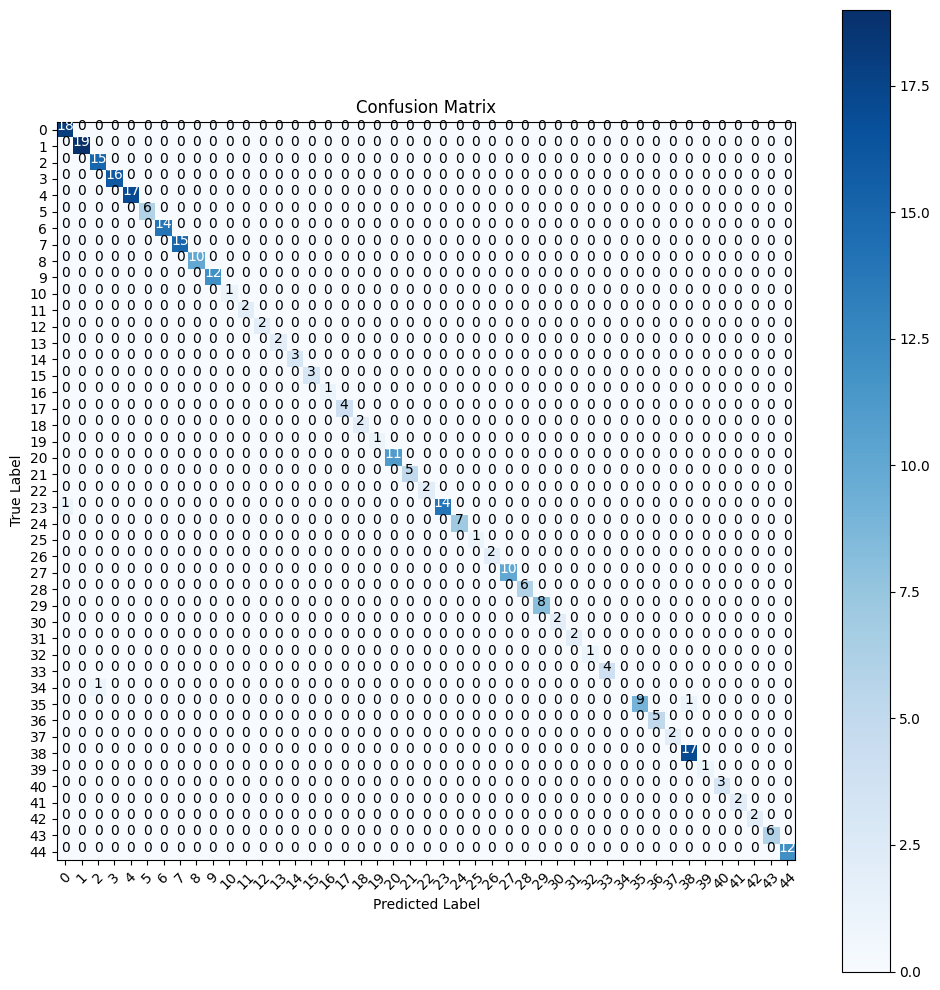

In [16]:
# Plot confusion matrix
def plot_confusion_mat(cm):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, tick_marks, rotation=45)
    plt.yticks(tick_marks, tick_marks)

    # Add labels in each cell
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_mat(loo_confusion_matrix)